# **Demand Forecasting for E-commerce and Banking Orders**

### Important Libraries

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Preprocessing & Outlier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Time series / stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Forecast auto-selection
!pip install -q pmdarima
import pmdarima as pm

# Box-Cox
from scipy import stats

# CV and metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utility
import math

### Load Dataset

In [ ]:
df = pd.read_csv('/content/Demand_Forecasting.csv')

### Explore the Dataset

In [ ]:
# Quick look
df.head()

,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [ ]:
# Column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          60 non-null     int64  
 1   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 2   Day of the week (Monday to Friday)                                  60 non-null     int64  
 3   Non-urgent order                                                    60 non-null     float64
 4   Urgent order                                                        60 non-null     float64
 5   Order type A                                                        60 non-null     float64
 6   Order type B                                                        60 non-null     float64
 7   Order type C       

In [ ]:
# Summary statistics (numerical)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,60.0,29.500000,17.464249,0.000,14.75000,29.5000,44.25000,59.000
"Week of the month (first week, second, third, fourth or fifth week",60.0,3.016667,1.282102,1.000,2.00000,3.0000,4.00000,5.000
Day of the week (Monday to Friday),60.0,4.033333,1.401775,2.000,3.00000,4.0000,5.00000,6.000
Non-urgent order,60.0,172.554933,69.505788,43.651,125.34800,151.0625,194.60650,435.304
Urgent order,60.0,118.920850,27.170929,77.371,100.88800,113.1145,132.10825,223.270
Order type A,60.0,52.112217,18.829911,21.826,39.45625,47.1665,58.46375,118.178
Order type B,60.0,109.229850,50.741388,25.125,74.91625,99.4820,132.17100,267.342
Order type C,60.0,139.531250,41.442932,74.372,113.63225,127.9900,160.10750,302.448
Fiscal sector orders,60.0,77.396133,186.502470,0.000,1.24325,7.8315,20.36075,865.000
Orders from the traffic controller sector,60.0,44504.350000,12197.905134,11992.000,34994.25000,44312.0000,52111.75000,71772.000


In [ ]:
df.shape

(60, 14)

### Data Cleaning

In [ ]:
# Check duplicate rows
df.duplicated().sum()

np.int64(0)

In [ ]:
# Check missing values
df.isnull().sum()

,0
Unnamed: 0,0
"Week of the month (first week, second, third, fourth or fifth week",0
Day of the week (Monday to Friday),0
Non-urgent order,0
Urgent order,0
Order type A,0
Order type B,0
Order type C,0
Fiscal sector orders,0
Orders from the traffic controller sector,0


In [ ]:
# Remove unwanted index-like column
df = df.drop(columns=["Unnamed: 0"])

In [ ]:
# Shape after cleaning
df.shape

(60, 13)

In [ ]:
# Show first few cleaned rows
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


### EDA (Exploratory Data Analysis)

In [ ]:
# Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
"Week of the month (first week, second, third, fourth or fifth week",60.0,3.016667,1.282102,1.000,2.00000,3.0000,4.00000,5.000
Day of the week (Monday to Friday),60.0,4.033333,1.401775,2.000,3.00000,4.0000,5.00000,6.000
Non-urgent order,60.0,172.554933,69.505788,43.651,125.34800,151.0625,194.60650,435.304
Urgent order,60.0,118.920850,27.170929,77.371,100.88800,113.1145,132.10825,223.270
Order type A,60.0,52.112217,18.829911,21.826,39.45625,47.1665,58.46375,118.178
Order type B,60.0,109.229850,50.741388,25.125,74.91625,99.4820,132.17100,267.342
Order type C,60.0,139.531250,41.442932,74.372,113.63225,127.9900,160.10750,302.448
Fiscal sector orders,60.0,77.396133,186.502470,0.000,1.24325,7.8315,20.36075,865.000
Orders from the traffic controller sector,60.0,44504.350000,12197.905134,11992.000,34994.25000,44312.0000,52111.75000,71772.000
Banking orders (1),60.0,46640.833333,45220.736293,3452.000,20130.00000,32527.5000,45118.75000,210508.000


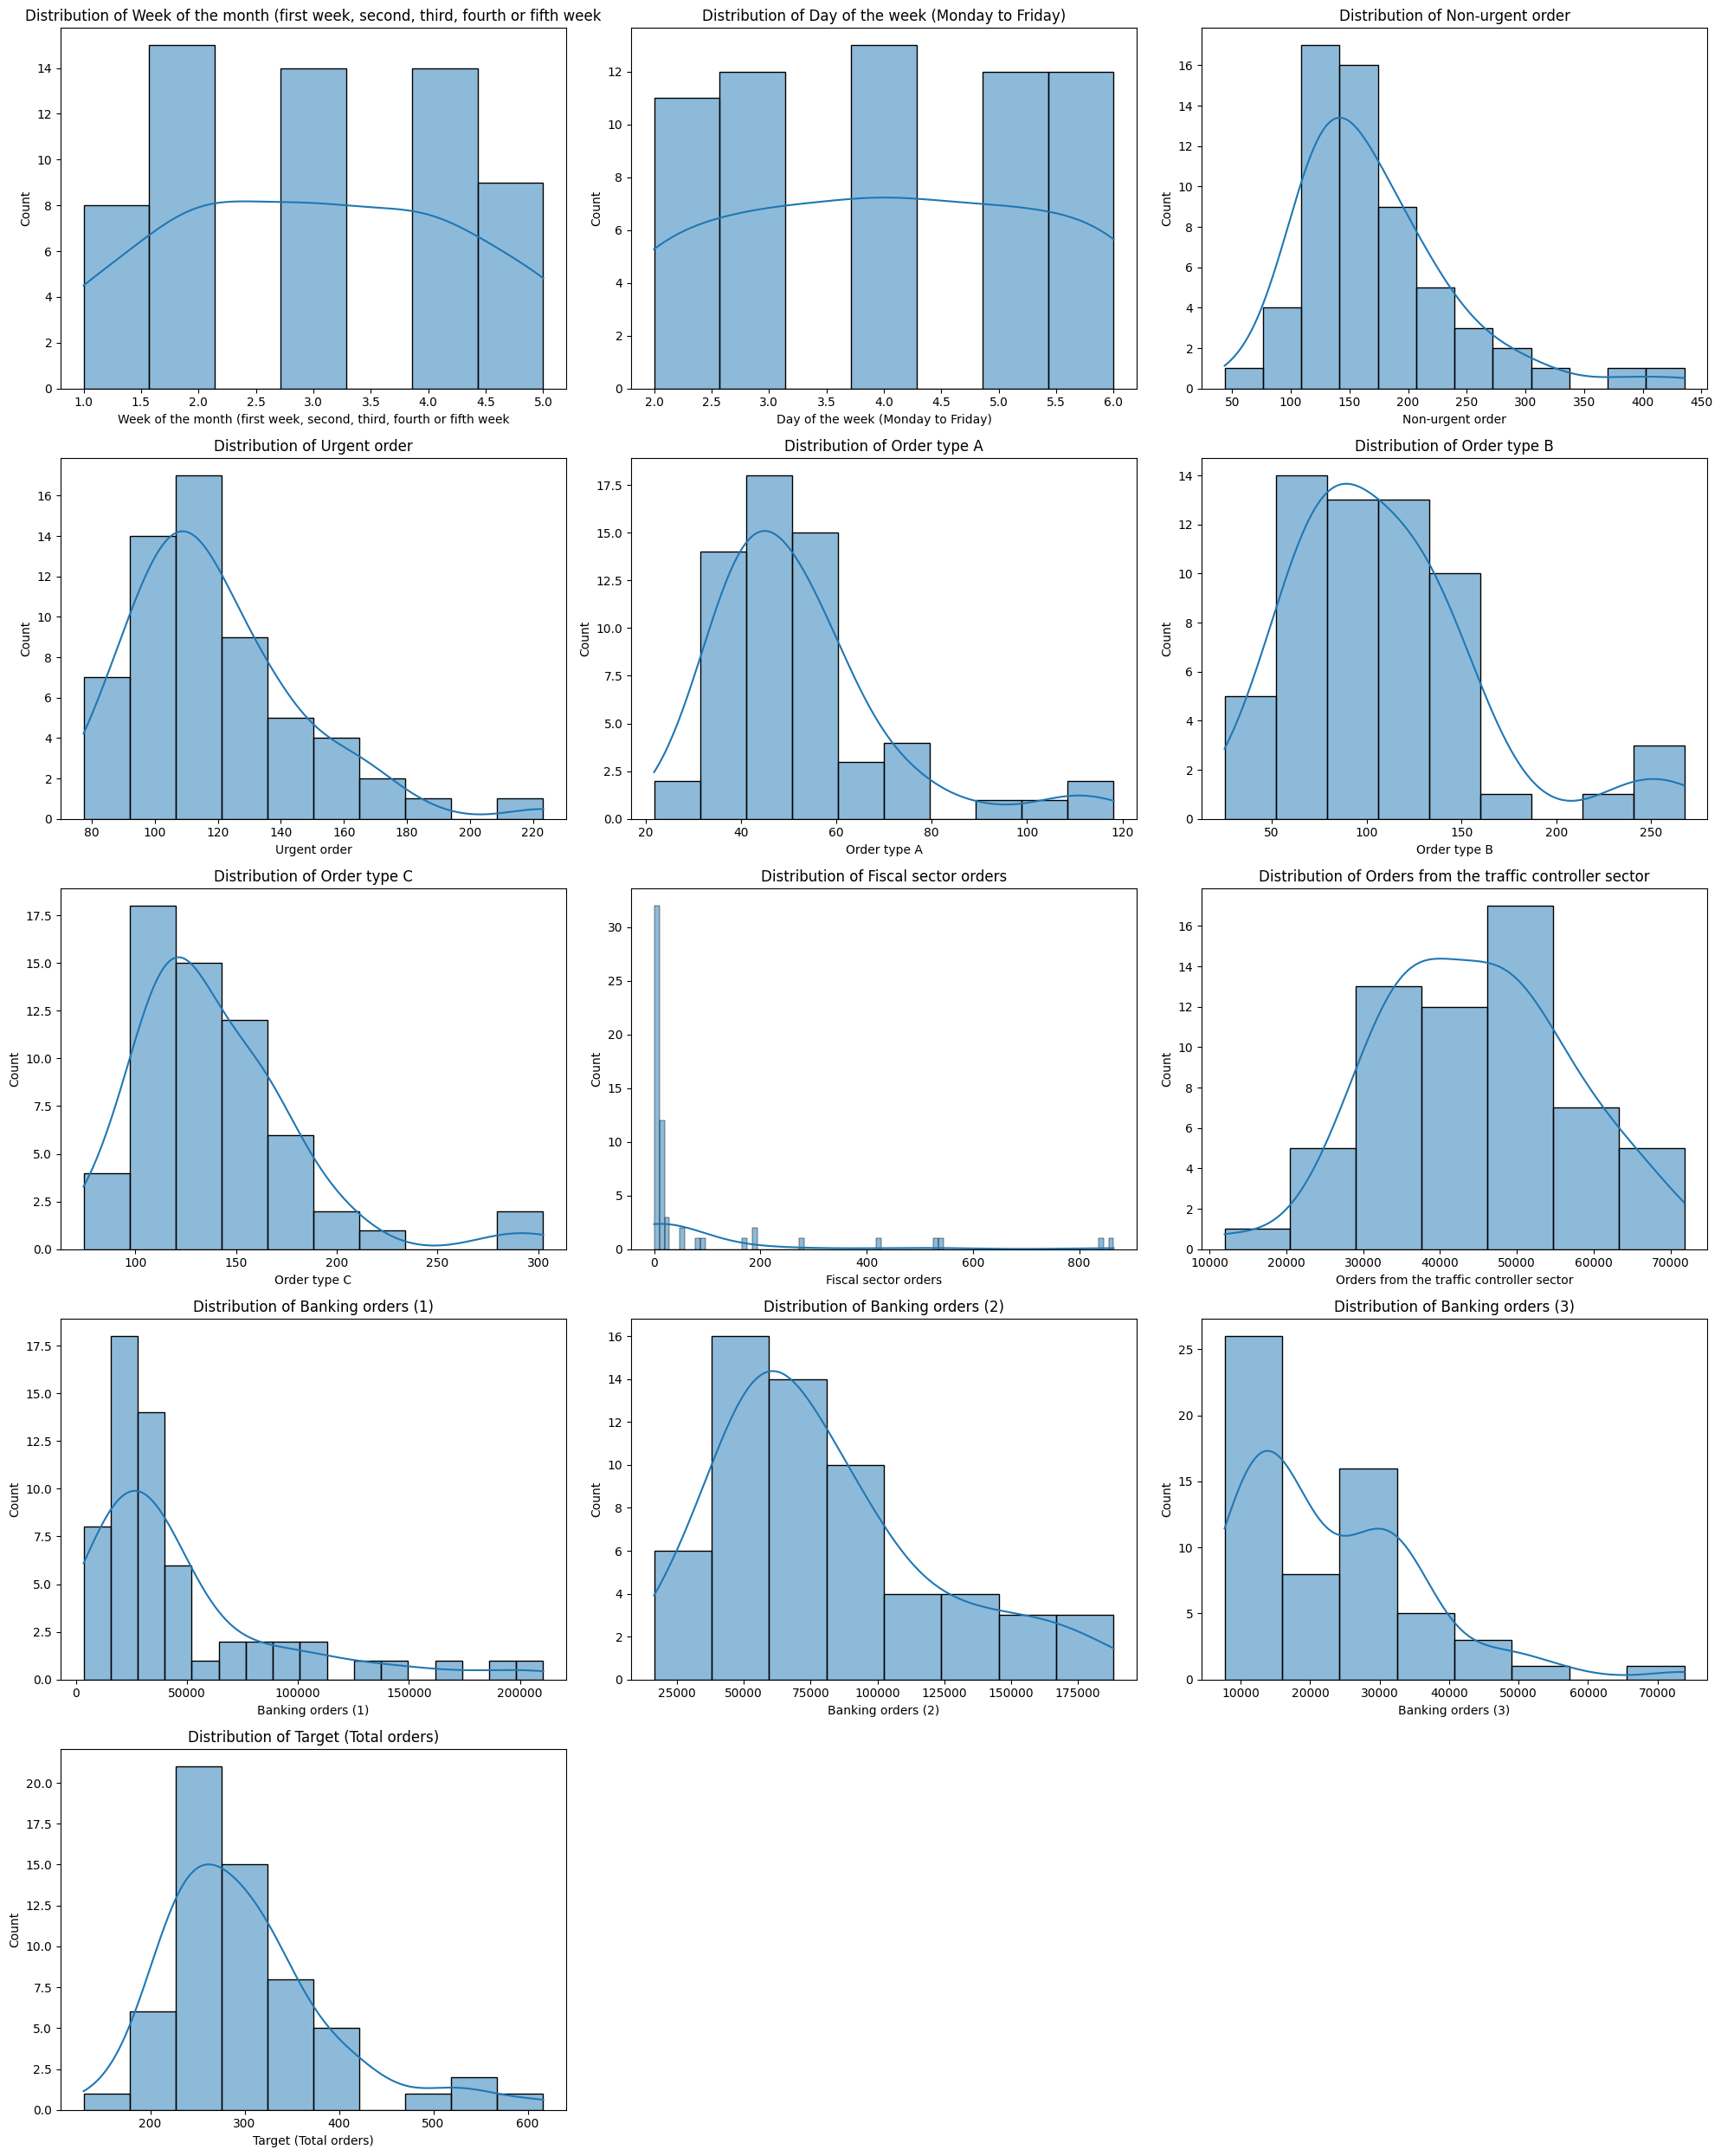

In [ ]:
# UNIVARIATE ANALYSIS

num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 1. Distribution plots for all numerical features
plt.figure(figsize=(20, 25))

for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

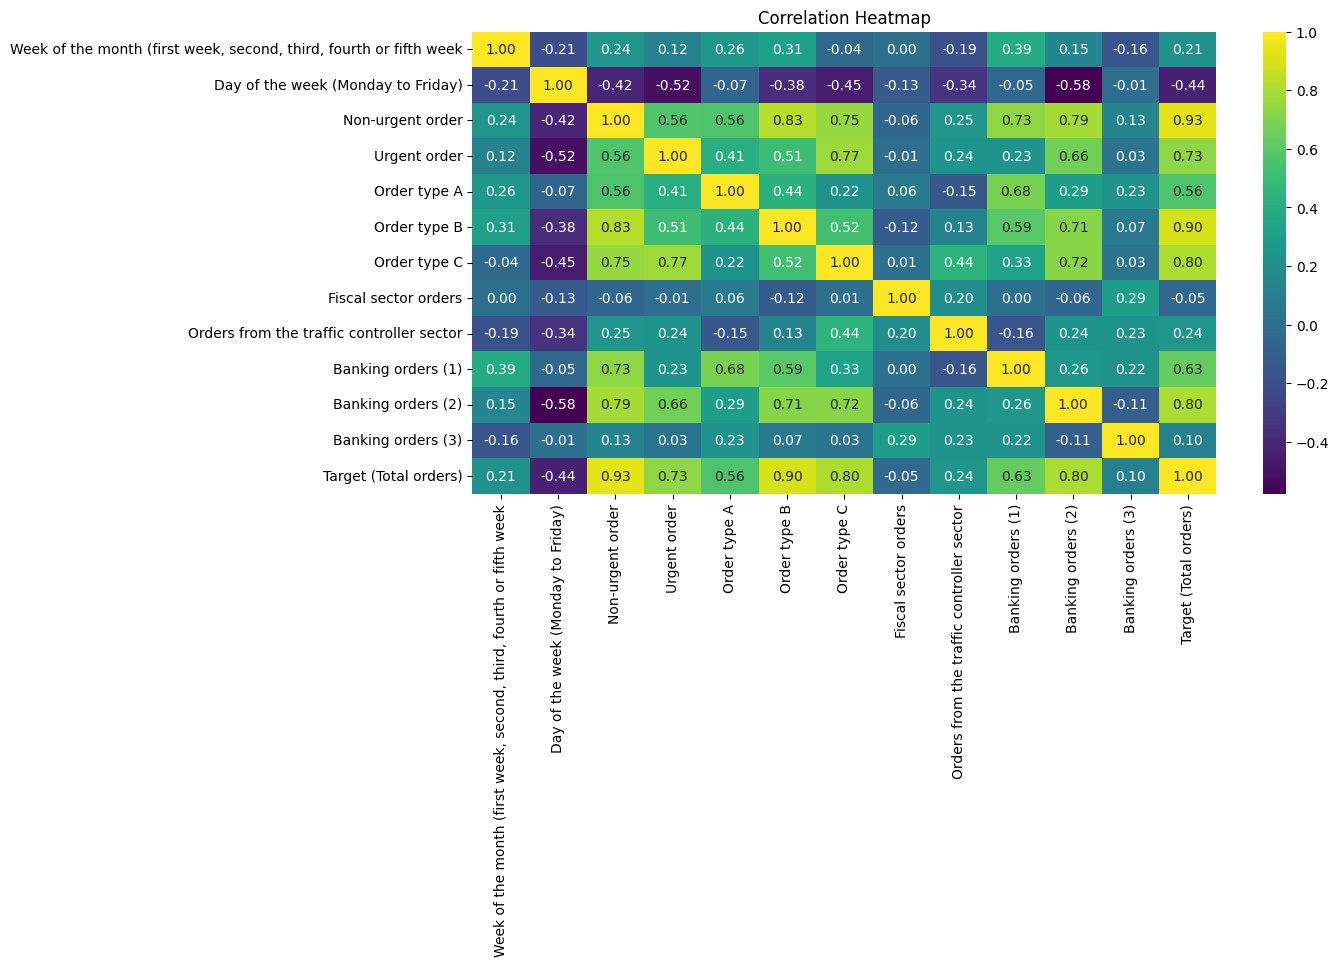

In [ ]:
# BIVARIATE ANALYSIS

target = "Target (Total orders)"

# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), cmap="viridis", annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

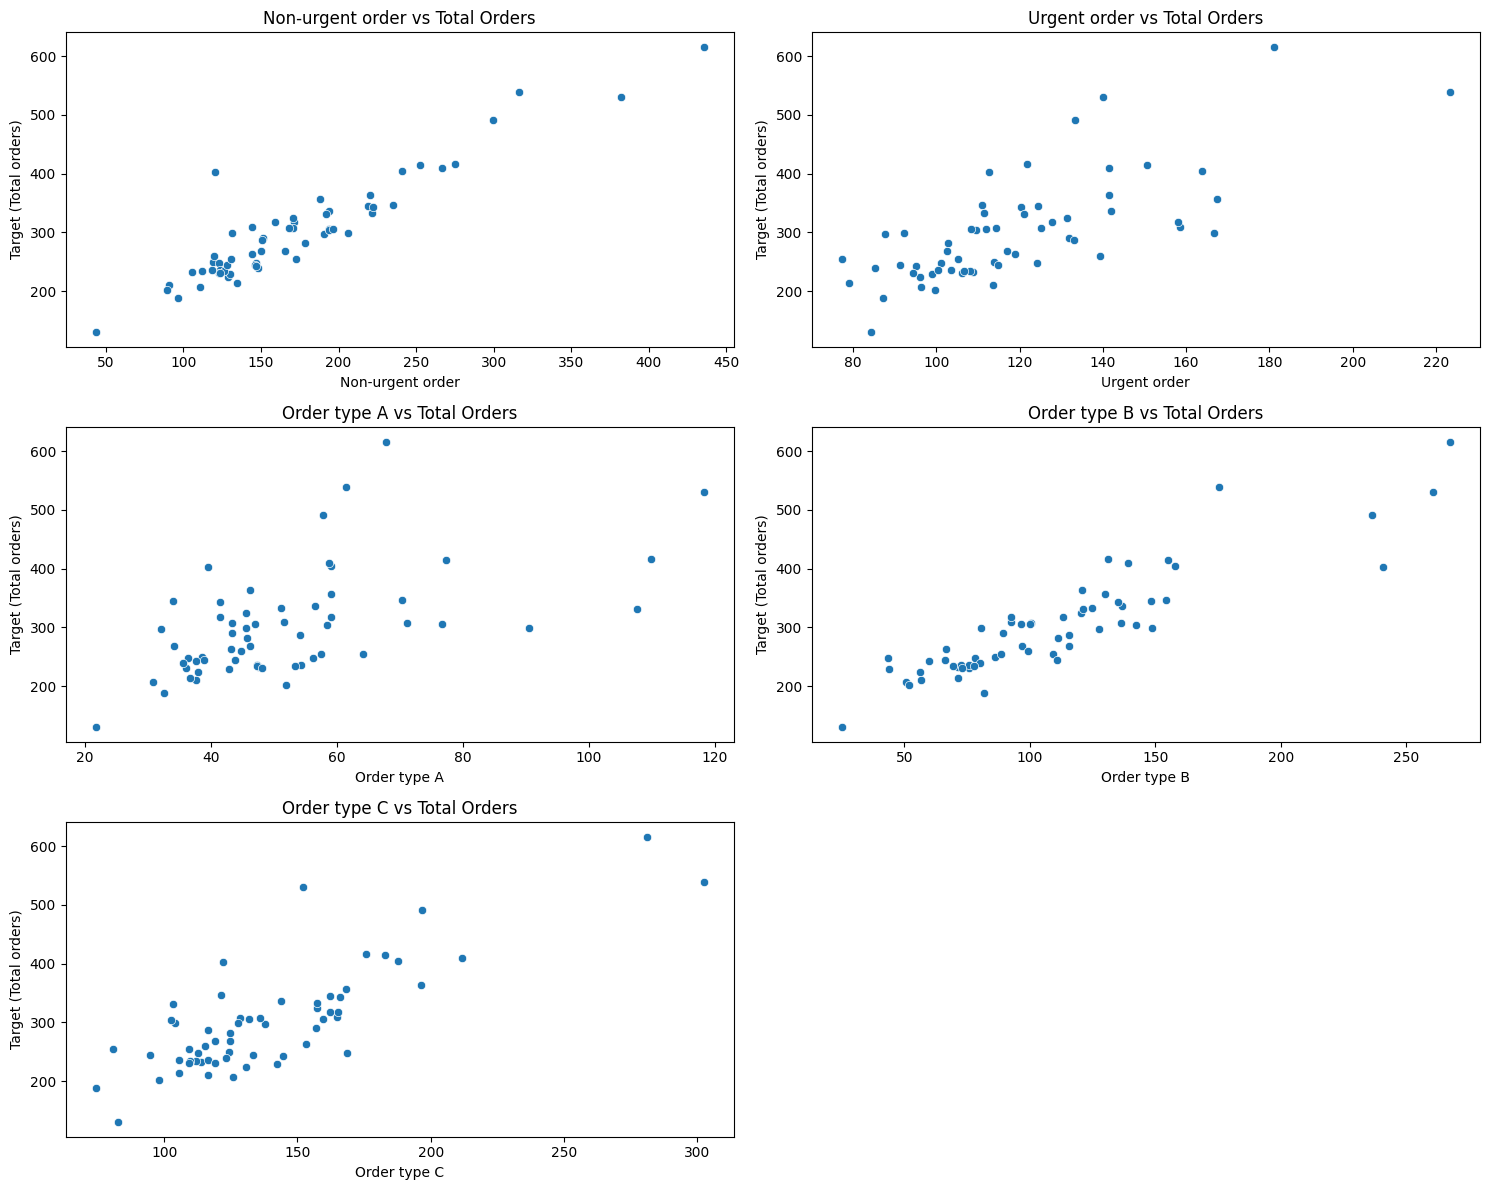

In [ ]:
# Target vs major order types
important_cols = [
    "Non-urgent order",
    "Urgent order",
    "Order type A",
    "Order type B",
    "Order type C"
]

plt.figure(figsize=(15, 12))
for i, col in enumerate(important_cols, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f"{col} vs Total Orders")

plt.tight_layout()
plt.show()

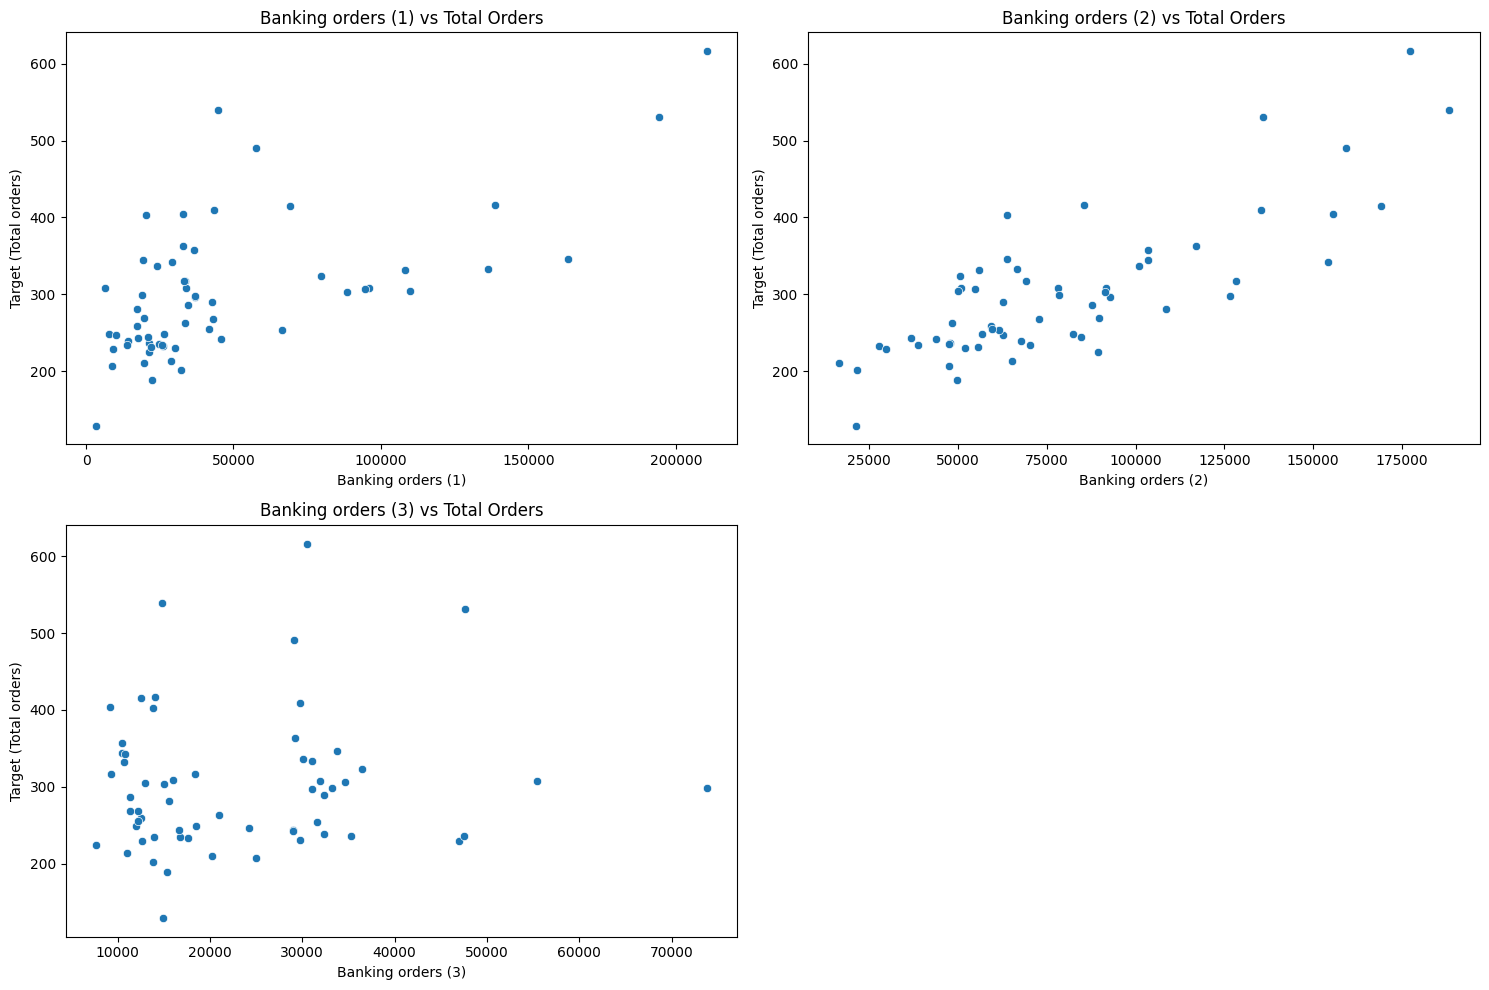

In [ ]:
# Banking orders vs Target
bank_cols = ["Banking orders (1)", "Banking orders (2)", "Banking orders (3)"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(bank_cols, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f"{col} vs Total Orders")

plt.tight_layout()
plt.show()

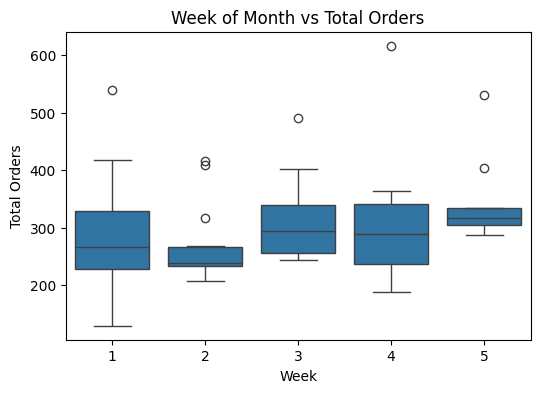

In [ ]:
# Week vs Total Orders (categorical relation)

week_col = [c for c in df.columns if "Week" in c][0]

plt.figure(figsize=(6, 4))
sns.boxplot(x=df[week_col], y=df[target])
plt.title("Week of Month vs Total Orders")
plt.xlabel("Week")
plt.ylabel("Total Orders")
plt.show()

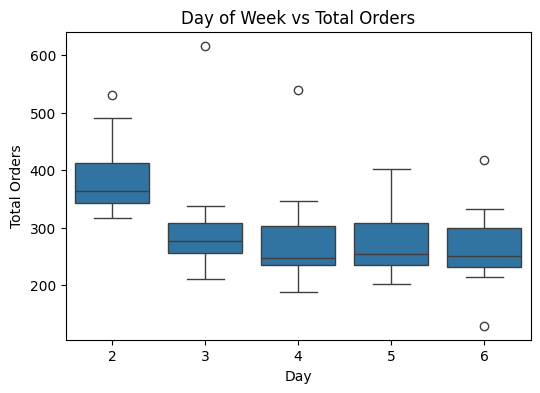

In [ ]:
# Day vs Total Orders
day_col = [c for c in df.columns if "Day" in c][0]

plt.figure(figsize=(6, 4))
sns.boxplot(x=df[day_col], y=df[target])
plt.title("Day of Week vs Total Orders")
plt.xlabel("Day")
plt.ylabel("Total Orders")
plt.show()

Outlier Detection (Univariate + Multivariate)

In [ ]:
# Outlier Detection (Univariate + Multivariate)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
target = "Target (Total orders)"

print("Numerical Columns:", list(num_cols))

Numerical Columns: ['Week of the month (first week, second, third, fourth or fifth week', 'Day of the week (Monday to Friday)', 'Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 'Order type C', 'Fiscal sector orders', 'Orders from the traffic controller sector', 'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)']


In [ ]:
# Univariate Outlier Detection (IQR Method)

def iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

outlier_summary = {}

for col in num_cols:
    lower, upper = iqr_bounds(df[col])
    outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()
    outlier_summary[col] = outliers

print("nUnivariate Outliers Detected (per feature):")
for col, count in outlier_summary.items():
    print(f"{col}: {count}")

nUnivariate Outliers Detected (per feature):
Week of the month (first week, second, third, fourth or fifth week: 0
Day of the week (Monday to Friday): 0
Non-urgent order: 4
Urgent order: 2
Order type A: 4
Order type B: 4
Order type C: 2
Fiscal sector orders: 13
Orders from the traffic controller sector: 0
Banking orders (1): 10
Banking orders (2): 3
Banking orders (3): 1
Target (Total orders): 4


In [ ]:
# Multivariate Outlier Detection (LOF)


lof = LocalOutlierFactor(n_neighbors=10)
lof_labels = lof.fit_predict(df[num_cols])

df["LOF_Flag"] = lof_labels  # -1 = outlier, 1 = inlier

print("Multivariate Outliers Detected:")
print("Outliers (LOF = -1):", sum(df["LOF_Flag"] == -1))

Multivariate Outliers Detected:
Outliers (LOF = -1): 5


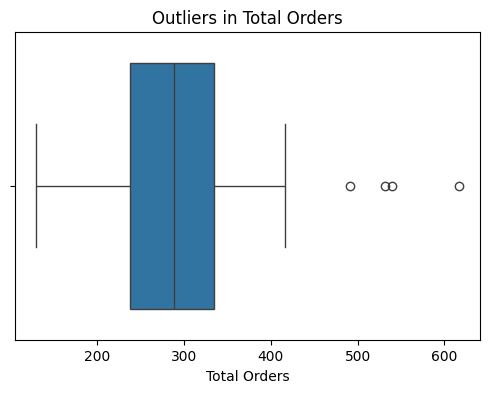

In [ ]:
# Visualizing Outliers (Target Variable)

plt.figure(figsize=(6,4))
sns.boxplot(x=df[target])
plt.title("Outliers in Total Orders")
plt.xlabel("Total Orders")
plt.show()

In [ ]:
# Capping Outliers (IQR Capping)

df_capped = df.copy()

for col in num_cols:
    lower, upper = iqr_bounds(df_capped[col])
    df_capped[col] = df_capped[col].clip(lower, upper)

# Capping completed. (We use capped data only for modeling if needed)

### Feature Engineering (Lag + Rolling + Ratio + Combined)

In [ ]:
# Lag Features
# Lag features help the model learn from previous time values.

df["lag_1"] = df[target].shift(1)
df["lag_2"] = df[target].shift(2)
df["lag_3"] = df[target].shift(3)

In [ ]:
# Rolling Window Features
# Rolling mean/std show short-term trends and variability.

df["roll_mean_3"] = df[target].rolling(window=3).mean().shift(1)
df["roll_std_3"] = df[target].rolling(window=3).std().shift(1)


In [ ]:
# Ratio Features
# Relationship between urgent / non-urgent behavior and total orders

df["urgent_ratio"] = df["Urgent order"] / (df[target] + 1)
df["nonurgent_ratio"] = df["Non-urgent order"] / (df[target] + 1)

In [ ]:
# Banking Orders Combined

bank_cols = ["Banking orders (1)", "Banking orders (2)", "Banking orders (3)"]
df["banking_total"] = df[bank_cols].sum(axis=1)

In [ ]:
# Drop Rows Created by Lagged Features
# First few rows become NaN due to shifting.

df_fe = df.dropna().reset_index(drop=True)
print("Shape after feature engineering:", df_fe.shape)

Shape after feature engineering: (57, 22)


In [ ]:
# Display first few rows
df_fe.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),...,Target (Total orders),LOF_Flag,lag_1,lag_2,lag_3,roll_mean_3,roll_std_3,urgent_ratio,nonurgent_ratio,banking_total
0,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,...,317.120,1,129.412,224.675,539.577,297.888000,214.660055,0.401317,0.538467,121180
1,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,...,210.517,1,317.120,129.412,224.675,223.735667,93.857525,0.536723,0.428013,56314
2,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,...,207.364,1,210.517,317.120,129.412,219.016333,94.142192,0.462460,0.532362,81261
3,2,5,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,...,263.043,1,207.364,210.517,317.120,245.000333,62.477357,0.450377,0.545835,102839
4,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,...,248.958,1,263.043,207.364,210.517,226.974667,31.275851,0.455557,0.477596,101445


### Clustering (K-Means + DBSCAN)

In [ ]:
# Select Features for Clustering

cluster_features = [
    "Non-urgent order",
    "Urgent order",
    "Order type A",
    "Order type B",
    "Order type C",
    "banking_total",
    "lag_1",
    "lag_2",
    "lag_3"
]

X_cluster = df_fe[cluster_features].copy()

In [ ]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

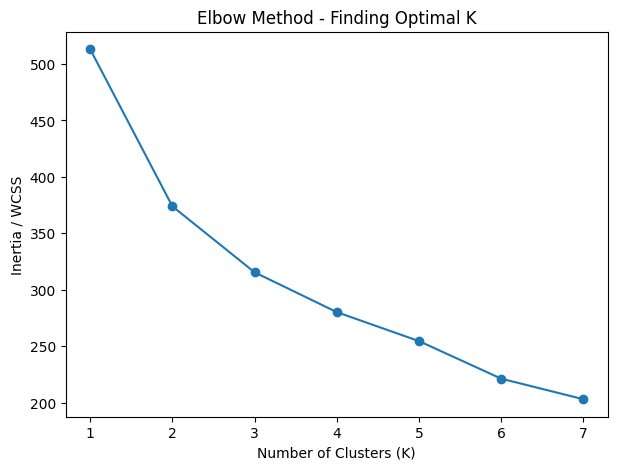

In [ ]:
# Elbow Method (Inertia / WCSS)

inertia_scores = []

for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(range(1, 8), inertia_scores, marker="o")
plt.title("Elbow Method - Finding Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia / WCSS")
plt.show()

In [ ]:
# optimal_k = x[np.argmax([abs(np.cross([x[-1]-x[0], y[-1]-y[0]], [x[0]-xi, y[0]-yi])) for xi, yi in zip(x, y)])]
# print(f"\nOptimal number of clusters (Auto Elbow Detection): (optimal_k}")

In [ ]:
# K-Means: Finding Best K using Silhouette Score

best_k = 2
best_score = -1

print("Calculating Silhouette Scores:")
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k = {k} → Silhouette Score = {round(score, 3)}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest K found: {best_k} with Silhouette Score: {round(best_score, 3)}")

Calculating Silhouette Scores:
k = 2 → Silhouette Score = 0.283
k = 3 → Silhouette Score = 0.193
k = 4 → Silhouette Score = 0.214
k = 5 → Silhouette Score = 0.177

Best K found: 2 with Silhouette Score: 0.283


In [ ]:
# Fit Final K-Means Model
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
df_fe["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

In [ ]:
# DBSCAN (Density-Based Clustering)
dbscan = DBSCAN(eps=0.8, min_samples=4)
df_fe["DBSCAN_Cluster"] = dbscan.fit_predict(X_scaled)

In [ ]:
# Agglomerative
agg = AgglomerativeClustering(n_clusters=best_k)
df_fe["Agglomerative_Cluster"] = agg.fit_predict(X_scaled)

In [ ]:
# Cluster Summary
print("K-Means Cluster Summary (Median Values):")
display(df_fe.groupby("KMeans_Cluster")[cluster_features].median())

print("\n\nDBSCAN Cluster Labels:")
print(df_fe["DBSCAN_Cluster"].value_counts())

print("\nAgglomerative label counts:")
print(df_fe["Agglomerative_Cluster"].value_counts())

K-Means Cluster Summary (Median Values):


,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,banking_total,lag_1,lag_2,lag_3
KMeans_Cluster,,,,,,,,,
0,222.2820,141.406,59.135,135.1890,165.999,202197.0,306.356,303.447,286.412
1,144.0875,107.348,44.330,87.2115,120.645,113805.0,268.321,268.321,268.321




DBSCAN Cluster Labels:
DBSCAN_Cluster
-1    57
Name: count, dtype: int64

Agglomerative label counts:
Agglomerative_Cluster
1    35
0    22
Name: count, dtype: int64


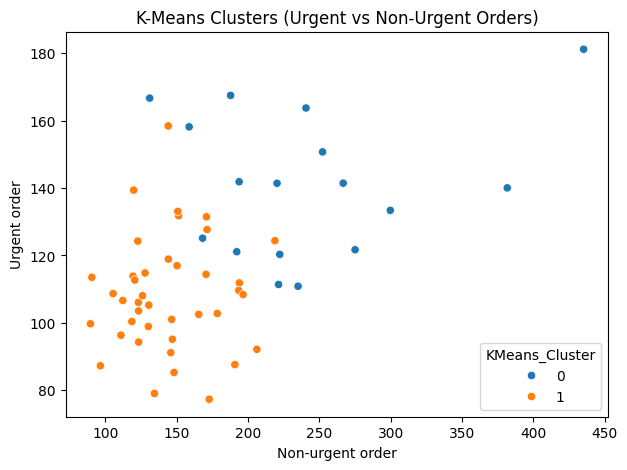

In [ ]:
# Simple Visualization for K-Means (2 variables)
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=df_fe["Non-urgent order"],
    y=df_fe["Urgent order"],
    hue=df_fe["KMeans_Cluster"]
)
plt.title("K-Means Clusters (Urgent vs Non-Urgent Orders)")
plt.show()

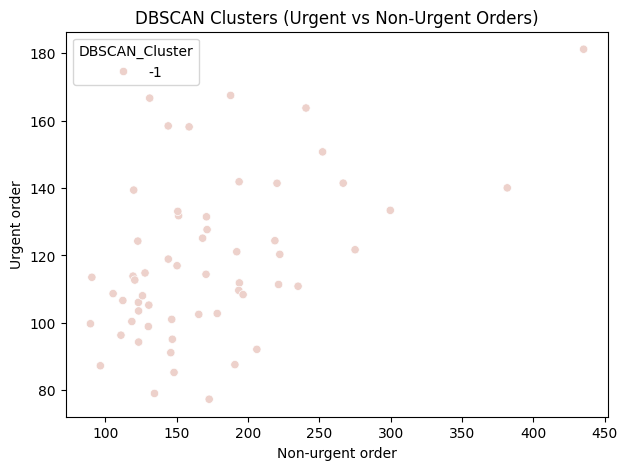

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=df_fe["Non-urgent order"],
    y=df_fe["Urgent order"],
    hue=df_fe["DBSCAN_Cluster"]
)
plt.title("DBSCAN Clusters (Urgent vs Non-Urgent Orders)")
plt.show()

### TIME SERIES PREPARATION

Time series length: 57


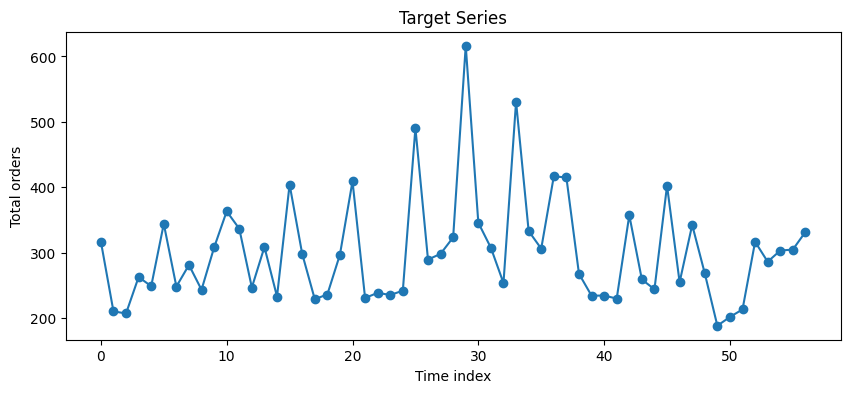

In [ ]:
ts = df_fe[target].reset_index(drop=True)
ts.index = pd.RangeIndex(start=0, stop=len(ts), step=1)
print("Time series length:", len(ts))

plt.figure(figsize=(10,4))
plt.plot(ts, marker='o')
plt.title("Target Series")
plt.xlabel("Time index"); plt.ylabel("Total orders")
plt.show()

In [ ]:
# Stationarity test - ADF
adf_res = adfuller(ts)
print("ADF Statistic:", adf_res[0], "p-value:", adf_res[1])

ADF Statistic: -6.5724351268210395 p-value: 7.874796774063617e-09


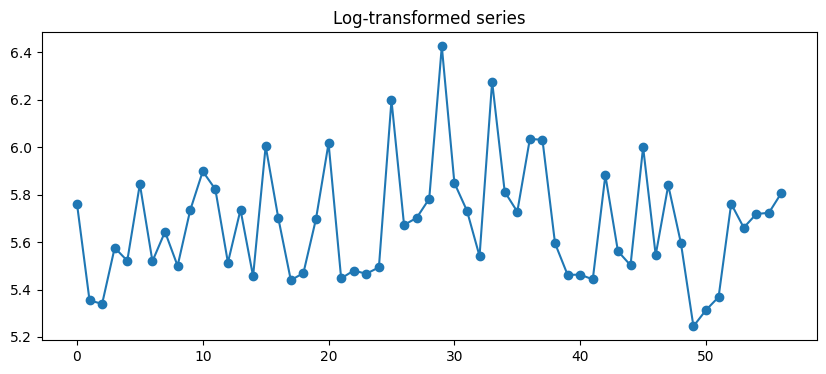

In [ ]:
# Log transform to stabilize variance
ts_log = np.log(ts + 1)
plt.figure(figsize=(10,4))
plt.plot(ts_log, marker='o')
plt.title("Log-transformed series")
plt.show()

### Seasonal decomposition for weekly check

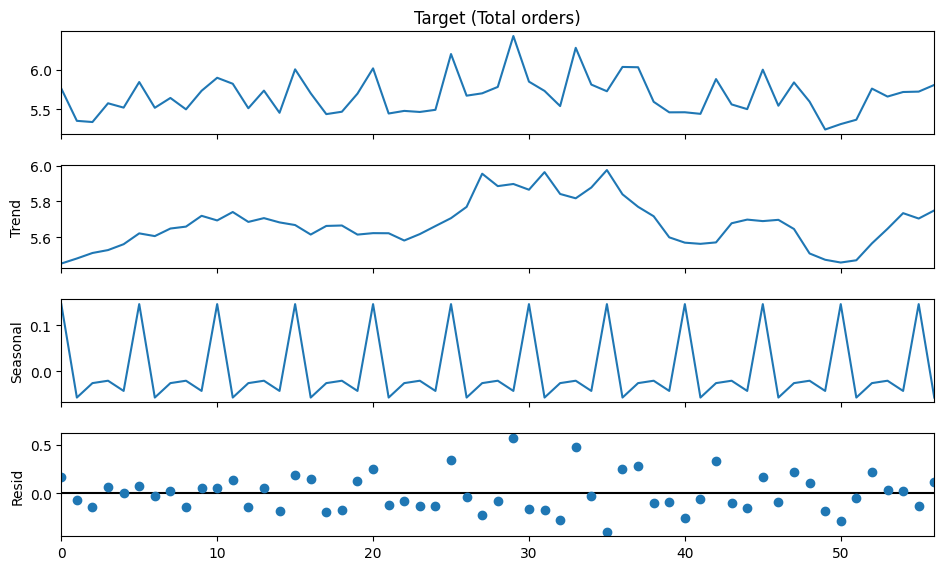

In [ ]:
# Seasonal_decompose requires at least two full periods; with small sample it may warn.
try:
    decomposition = seasonal_decompose(ts_log, period=5, model="additive", extrapolate_trend='freq')  # ADDED
    fig = decomposition.plot()
    fig.set_size_inches(10,6)
    plt.show()
except Exception as e:
    print("Seasonal decomposition skipped (insufficient length / frequency):", e)

### AUTO ARIMA

In [ ]:
# We fit on full log-series
FORECAST_HORIZON = 8

auto_model = pm.auto_arima(ts_log, start_p=0, start_q=0, max_p=5, max_q=5,
                           seasonal=False, stepwise=True, suppress_warnings=True,
                           error_action='ignore', trace=False)
print("ARIMA order:", auto_model.order)

# Forecast future points
forecast_log = auto_model.predict(n_periods=FORECAST_HORIZON)
forecast_arima = np.exp(forecast_log) - 1  # reverse log

ARIMA order: (0, 0, 0)


In [ ]:
# ARIMA Evaluation
actual = ts[-FORECAST_HORIZON:].values
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
def mape(a,b): return np.mean(np.abs((a-b)/(a+1))) * 100

print("ARIMA Evaluation:")
print("RMSE:", round(rmse(actual, forecast_arima),3))
print("MAE :", round(mean_absolute_error(actual, forecast_arima),3))
print("MAPE:", round(mape(actual, forecast_arima),3))

ARIMA Evaluation:
RMSE: 58.497
MAE : 45.825
MAPE: 20.627


In [ ]:
arima_df = pd.DataFrame({"Actual": actual, "ARIMA_Forecast": forecast_arima})
display(arima_df)

,Actual,ARIMA_Forecast
57,188.601,291.700192
58,202.022,291.700192
59,213.509,291.700192
60,316.849,291.700192
61,286.412,291.700192
62,303.447,291.700192
63,304.950,291.700192
64,331.900,291.700192


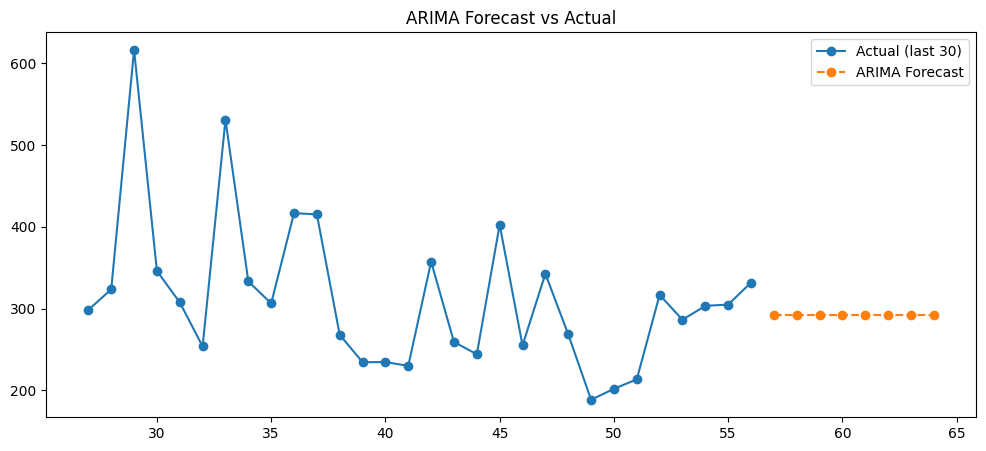

In [ ]:
# ARIMA plot
plt.figure(figsize=(12,5))
plt.plot(ts[-30:], marker='o', label="Actual (last 30)")
plt.plot(range(len(ts), len(ts)+FORECAST_HORIZON), forecast_arima, marker='o', linestyle='--', label="ARIMA Forecast")
plt.legend(); plt.title("ARIMA Forecast vs Actual")
plt.show()

### SARIMA Modeling

In [ ]:
sarima_order = auto_model.order
seasonal_order = (0, 0, 0, 5)

print("Fitting SARIMA:", sarima_order, seasonal_order)
# REPLACED: add enforce_stationarity/invertibility False for robustness
sarima_model = SARIMAX(ts_log, order=sarima_order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

Fitting SARIMA: (0, 0, 0) (0, 0, 0, 5)


In [ ]:
# SARIMA forecast on log scale
sarima_forecast_log = sarima_fit.get_forecast(steps=FORECAST_HORIZON).predicted_mean
sarima_forecast = np.exp(sarima_forecast_log) - 1

In [ ]:
# SARIMA Evaluation
print("SARIMA Evaluation:")
print("RMSE:", round(rmse(actual, sarima_forecast),3))
print("MAE :", round(mean_absolute_error(actual, sarima_forecast),3))
print("MAPE:", round(mape(actual, sarima_forecast),3))

SARIMA Evaluation:
RMSE: 273.776
MAE : 268.461
MAPE: 99.612


In [ ]:
sarima_df = pd.DataFrame({"Actual": actual, "SARIMA_Forecast": sarima_forecast})
display(sarima_df)

,Actual,SARIMA_Forecast
57,188.601,0.0
58,202.022,0.0
59,213.509,0.0
60,316.849,0.0
61,286.412,0.0
62,303.447,0.0
63,304.950,0.0
64,331.900,0.0


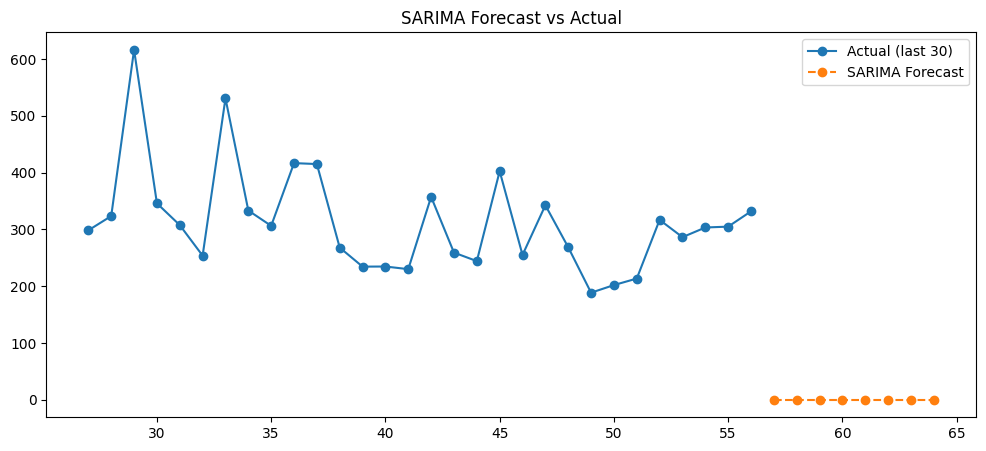

In [ ]:
# SARIMA plot
plt.figure(figsize=(12,5))
plt.plot(ts[-30:], marker='o', label="Actual (last 30)")
plt.plot(range(len(ts), len(ts)+FORECAST_HORIZON), sarima_forecast, marker='o', linestyle='--', label="SARIMA Forecast")
plt.legend(); plt.title("SARIMA Forecast vs Actual")
plt.show()

### TREND ANALYSIS

In [ ]:
if len(forecast_arima) >= 2:
    forecast_arr = np.array(forecast_arima)
    trend_percent = ((forecast_arr[-1] - forecast_arr[0]) / (forecast_arr[0] + 1)) * 100
    print("Trend % Change (ARIMA forecast):", round(trend_percent, 2), "%")
    if trend_percent > 5:
        print("Overall Trend: UPWARD")
    elif trend_percent < -5:
        print("Overall Trend: DOWNWARD")
    else:
        print("Overall Trend: STABLE")
else:
    print("Not enough forecast points for trend percentage calculation.")

Trend % Change (ARIMA forecast): 0.0 %
Overall Trend: STABLE


### FINAL RESULT EXPORT

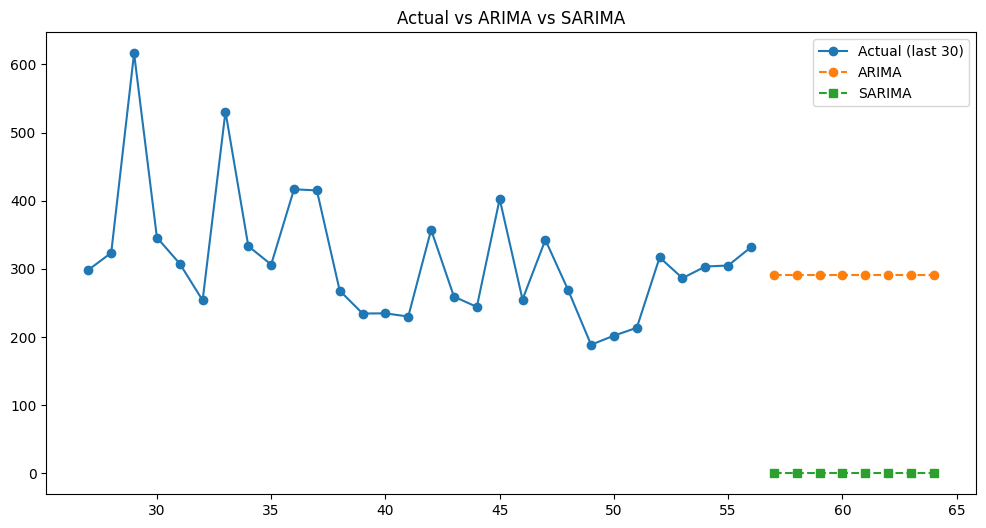

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(ts[-30:], marker='o', label="Actual (last 30)")
plt.plot(range(len(ts), len(ts)+FORECAST_HORIZON), forecast_arima, marker='o', linestyle='--', label="ARIMA")
plt.plot(range(len(ts), len(ts)+FORECAST_HORIZON), sarima_forecast, marker='s', linestyle='--', label="SARIMA")
plt.title("Actual vs ARIMA vs SARIMA")
plt.legend(); plt.show()

In [ ]:
# EXPORT combined results
result_df = pd.DataFrame({
    "Actual": actual,
    "ARIMA_Forecast": np.round(forecast_arima, 3),
    "SARIMA_Forecast": np.round(sarima_forecast, 3)
})
print("\nFinal Combined Forecast Table:")
display(result_df)


Final Combined Forecast Table:


,Actual,ARIMA_Forecast,SARIMA_Forecast
57,188.601,291.7,0.0
58,202.022,291.7,0.0
59,213.509,291.7,0.0
60,316.849,291.7,0.0
61,286.412,291.7,0.0
62,303.447,291.7,0.0
63,304.950,291.7,0.0
64,331.900,291.7,0.0


In [ ]:
result_df.to_csv("Final_Forecasts_ARIMA_SARIMA.csv", index=False)
print("\nSaved: Final_Forecasts_ARIMA_SARIMA.csv")


Saved: Final_Forecasts_ARIMA_SARIMA.csv
